## Evaluating our retrieval performance
- Basic string matching
- Levenshtein edit distance (pairwise)
- Jaro-Winkler distance

- !! need to use song and artist strings separately, then compute similarity metric

In [89]:

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [90]:
## HELPER FUNCTION
import unicodedata
def shave_marks(txt):
    """This method removes all diacritic marks from the given string"""
    norm_txt = unicodedata.normalize('NFD', txt)
    shaved = ''.join(c for c in norm_txt if not unicodedata.combining(c))
    return unicodedata.normalize('NFC', shaved)

In [91]:
search_df = pd.read_csv("data/dataSpotify.csv")

In [92]:
print(search_df.shape)
search_df.head()

(31054, 11)


,SongNumber,Title,ArtistName,SearchStr,market,SearchStr_nopar,SearchStr_decode_nopar,SongID,SpotifySongTitle,SpotifyArtistTitle,Popularity
0,77629,Fire Dance,STRATOVARIUS,fire dance stratovarius,it,fire dance stratovarius,fire dance stratovarius,3YOhXYCLFRQxEmUlzjiWEJ,Fire Dance,Stratovarius,17.0
1,575703,Don't Worry,Fred Thomas,don't worry fred thomas,us,don't worry fred thomas,don't worry fred thomas,53RfjM48r9xNywpDiog6zG,Don't Worry,Fred Thomas,1.0
2,857332,Guess Who's Coming To Dinner,Chops,guess who's coming to dinner chops,us,guess who's coming to dinner chops,guess who's coming to dinner chops,NaN,guess who's coming to dinner chops,NaN,NaN
3,44180,Deep River (part two),The Five Blind Boys Of Alabama,deep river (part two) the five blind boys of a...,us,deep river the five blind boys of alabama,deep river the five blind boys of alabama,3XeMKCwdyW5aRqbpR9zMal,Look Where He Brought Me From,The Blind Boys Of Alabama,11.0
4,239962,Intro/Love Line Interlude1,Deviants of Reality,intro/love line interlude1 deviants of reality,us,intro/love line interlude1 deviants of reality,intro/love line interlude1 deviants of reality,73vcZCFNErwqHxuS1BXH0e,Intro/Love Line Interlude 1,Deviants Of Reality,0.0


In [93]:
## see which and how many values match both song and artist name as is; ~4053 rows
len(search_df[(search_df.SpotifyArtistTitle == search_df.ArtistName) & (search_df.SpotifySongTitle == search_df.Title)])

12854

In [94]:
## after pre-processing, same process as with the search strings
## get the search string by concatenating, remove parenthesis, and use decoding function to remove funky chars
# search_df

search_df["SpotifySearchStr"] = search_df["SpotifySongTitle"] + " " + search_df["SpotifyArtistTitle"]
search_df["SpotifySearchStr"] = search_df["SpotifySearchStr"].apply(lambda x: str(x).lower())

search_df["SpotifySearchStr_nopar"] = search_df.SpotifySearchStr.apply(lambda x: re.sub("\(.*\)", "", x))
search_df["SpotifySearchStr_decode_nopar"] = search_df["SpotifySearchStr_nopar"].apply(lambda x: shave_marks(x))

In [95]:
search_df = search_df.dropna(subset=["SearchStr_decode_nopar", "SpotifySearchStr_decode_nopar"])
search_df.shape

(31054, 14)

In [96]:
## let's now see how many exact _decode_nopar strings are in our date, popularity not null; ~3530
## save it as a df subset to work with simlarity measures

# not_match = search_df[(search_df["SpotifySearchStr_decode_nopar"] != search_df["SearchStr_decode_nopar"]) & (~search_df["Popularity"].isna())]

In [97]:
# not_match

In [98]:
## install levenshtein package to compute edit distances
# ! pip install python-Levenshtein

## install jaro-winkler package for alternate string similarity metric
# ! pip install pyjarowinkler


In [101]:
## compute levenshtein edit distance for the subset
import Levenshtein
from pyjarowinkler import distance

## list of tups, containing pairs for calculation
l_pairs = list(zip(search_df.SearchStr_decode_nopar.values,  search_df.SpotifySearchStr_decode_nopar.values))
distances = []
for p in l_pairs:
    ## L distance
    dist = Levenshtein.distance(p[0], p[1]) / len(p[0]+p[1])
    ## JW distance
    dist = distance.get_jaro_distance(p[0], p[1], winkler=True, scaling=0.1)
    # print(p)
    # print(dist)

    distances.append(dist)

In [102]:
len(distances)

31054

In [103]:
# distances
search_df["JWdistance"] = distances

In [104]:
## filter our columns to observe what's up with distance
_subset = search_df[['SongNumber', 'SearchStr_decode_nopar', 'SpotifySearchStr_decode_nopar', 'JWdistance']].sample(15)
_subset.sample(4)

,SongNumber,SearchStr_decode_nopar,SpotifySearchStr_decode_nopar,JWdistance
25225,566521,holy is his name john michael talbot,holy is his name john michael talbot,0.96
4788,308644,mechanikal breakdown v/a friction records,nan,0.00
12289,150050,asa nisi masa diskjokke,asa nisi masa diskjokke,1.00
26422,646771,it's warmer in the basement cobra starship,it's warmer in the basement cobra starship,1.00


In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("fivethirtyeight")

%matplotlib inline

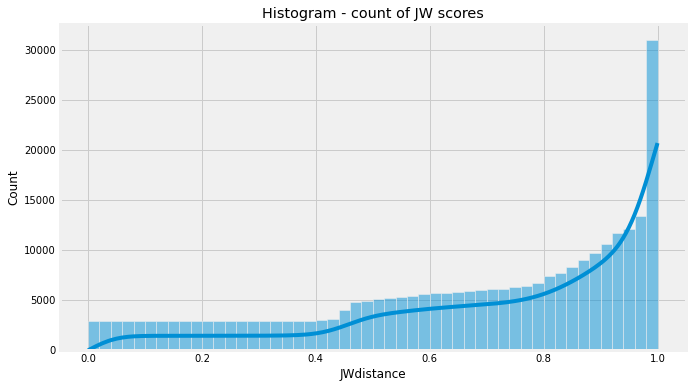

In [106]:
## viz, see distribution of our distance scores, overall how well we performed
## summary statistics
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(data=search_df, x='JWdistance', ax=ax, bins=50, kde=True, cumulative=True)
plt.title("Histogram - count of JW scores");

In [107]:
## summary descriptive statistics; use the Q1 score to keep 75% of data, based on JW score cutoff
JW_cutoff = search_df.JWdistance.describe()["25%"]
print(JW_cutoff)

0.84


In [111]:
## Let's try to find a good threshold to determine if the correct song was retrieve from Spotify.
## ~.72 is a good threshold, upon manual inspection. This SHOULD be modifiable to make more conservative or liberal choices

threshold_df = search_df[search_df.JWdistance >= JW_cutoff].reset_index(drop=True)
threshold_df.shape
## keep 75% of the data (pyjarowinkler)
## we keep 7587 rows, in the subset. Save this as a variation of the original "dataSpotify.csv" and remove the JW score column

(23320, 15)

In [109]:
## drop before writing it again
threshold_df = threshold_df.drop("JWdistance", axis=1)
threshold_df

,SongNumber,Title,ArtistName,SearchStr,market,SearchStr_nopar,SearchStr_decode_nopar,SongID,SpotifySongTitle,SpotifyArtistTitle,Popularity,SpotifySearchStr,SpotifySearchStr_nopar,SpotifySearchStr_decode_nopar
0,77629,Fire Dance,STRATOVARIUS,fire dance stratovarius,it,fire dance stratovarius,fire dance stratovarius,3YOhXYCLFRQxEmUlzjiWEJ,Fire Dance,Stratovarius,17.0,fire dance stratovarius,fire dance stratovarius,fire dance stratovarius
1,575703,Don't Worry,Fred Thomas,don't worry fred thomas,us,don't worry fred thomas,don't worry fred thomas,53RfjM48r9xNywpDiog6zG,Don't Worry,Fred Thomas,1.0,don't worry fred thomas,don't worry fred thomas,don't worry fred thomas
2,239962,Intro/Love Line Interlude1,Deviants of Reality,intro/love line interlude1 deviants of reality,us,intro/love line interlude1 deviants of reality,intro/love line interlude1 deviants of reality,73vcZCFNErwqHxuS1BXH0e,Intro/Love Line Interlude 1,Deviants Of Reality,0.0,intro/love line interlude 1 deviants of reality,intro/love line interlude 1 deviants of reality,intro/love line interlude 1 deviants of reality
3,793702,Danny Boy,Foster & Allen,danny boy foster & allen,us,danny boy foster & allen,danny boy foster & allen,5V2GVAhUtjXwEfYNUjDUyz,Danny Boy,Foster & Allen,26.0,danny boy foster & allen,danny boy foster & allen,danny boy foster & allen
4,394778,Postcard,Finn's Motel,postcard finn's motel,us,postcard finn's motel,postcard finn's motel,0Qdy0Vu9xir8mjc6iQ6vTA,Postcard,Finn's Motel,0.0,postcard finn's motel,postcard finn's motel,postcard finn's motel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23315,258287,I Think I'm In Trouble,Exposé,i think i'm in trouble exposé,us,i think i'm in trouble exposé,i think i'm in trouble expose,5kJskmLBJPd5KeiSRmBKA2,I Think I'm In Trouble,Exposé,16.0,i think i'm in trouble exposé,i think i'm in trouble exposé,i think i'm in trouble expose
23316,801591,Subtellite (Argy Remix),Timo Maas,subtellite (argy remix) timo maas,us,subtellite timo maas,subtellite timo maas,4zCIw0L2LymZ4iHSU0T9Et,Subtellite,Timo Maas,16.0,subtellite timo maas,subtellite timo maas,subtellite timo maas
23317,862112,Bill Gates_ komm...,Welle: Erdball,bill gates_ komm... welle: erdball,us,bill gates_ komm... welle: erdball,bill gates_ komm... welle: erdball,0qBxAcenqF2lwbGi0HRZpW,"Bill Gates, komm fick mit mir!",Welle: Erdball,15.0,"bill gates, komm fick mit mir! welle: erdball","bill gates, komm fick mit mir! welle: erdball","bill gates, komm fick mit mir! welle: erdball"
23318,286275,Love Found Me,DecembeRadio,love found me decemberadio,us,love found me decemberadio,love found me decemberadio,3O9TJ95zrSqlg5Qk9BBq4V,Love Found Me,DecembeRadio,14.0,love found me decemberadio,love found me decemberadio,love found me decemberadio


In [110]:
# threshold_df.to_csv("data/dataSpotifyJW.csv", index=False)
